# Probabilistic solvers as collocation methods

Probabilistic solvers condition a prior distribution on satisfying an ODE on a specified grid.


In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from diffeqzoo import backend, ivps
from jax.config import config

from probdiffeq import controls, ivpsolve, ivpsolvers, solution
from probdiffeq.doc_util import notebook
from probdiffeq.statespace import recipes
from probdiffeq.strategies import smoothers

In [2]:
plt.rcParams.update(notebook.plot_config())

if not backend.has_been_selected:
    backend.select("jax")  # ivp examples in jax

config.update("jax_platform_name", "cpu")

In [3]:
# Make a problem
f, u0, (t0, t1), f_args = ivps.affine_independent()
f_vect = jax.vmap(f, in_axes=(0, None, None))


@jax.jit
def vector_field(y, *, t, p):
    return f(y, *p)


# Make a solver
impl = recipes.slr1_dense(ode_shape=(1,), num_derivatives=1)
solver = ivpsolvers.MLESolver(smoothers.Smoother(*impl))

In [4]:
# Solve the ODE with low precision
sol = ivpsolve.solve_with_python_while_loop(
    vector_field,
    initial_values=(u0[None],),
    t0=t0,
    t1=t1,
    rtol=1e-2,
    solver=solver,
    parameters=f_args,
    control=controls.IntegralClipped(),
)

In [5]:
# Evalate the posterior on a dense grid

eps = 1e-4
mesh = jnp.linspace(t0 + eps, t1 - eps, num=50, endpoint=True)
_, marginals = solution.offgrid_marginals_searchsorted(
    ts=mesh, solution=sol, solver=solver
)

posterior_u = marginals.marginal_nth_derivative(0).mean
posterior_du = marginals.marginal_nth_derivative(1).mean

In [6]:
# Extrapolate the prior on the dense grid

extrapolation_model = solver.strategy.extrapolation
taylor_coefficients = jnp.reshape(
    sol.marginals.mean[0, ...],
    sol.marginals.target_shape,
    order="F",
)


prior_u = []
prior_du = []
rv = extrapolation_model.filter_solution_from_tcoeffs(taylor_coefficients)
ssv, extra = extrapolation_model.filter_init(rv)
for t_old, t_new in zip(mesh[:-1], mesh[1:]):
    prior_u.append(rv.marginal_nth_derivative(0).mean)
    prior_du.append(rv.marginal_nth_derivative(1).mean)

    dt = t_new - t_old
    ssv, extra = extrapolation_model.filter_begin(ssv, extra, dt)
    ssv, extra = extrapolation_model.filter_complete(
        ssv, extra, output_scale=sol.output_scale.mean()
    )
    rv = extrapolation_model.filter_extract(ssv, extra)


prior_u.append(rv.marginal_nth_derivative(0).mean)
prior_du.append(rv.marginal_nth_derivative(1).mean)

prior_u = jnp.asarray(prior_u)
prior_du = jnp.asarray(prior_du)

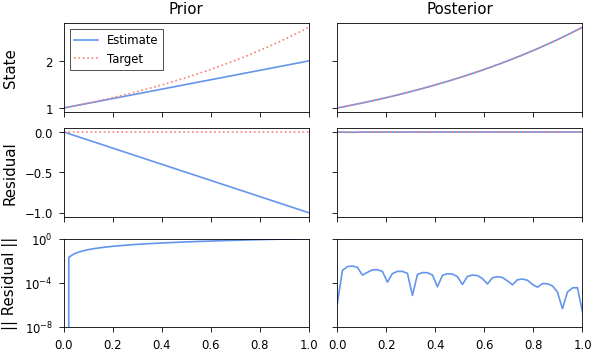

In [7]:
# Plot the samples

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(5, 3), sharex=True, sharey="row")
((ax0, ax1), (ax2, ax3), (ax4, ax5)) = axes


#######################
ax0.set_ylabel("State")

ax0.set_title("Prior")
ax0.plot(mesh, prior_u, marker="None", label="Estimate")
ax0.plot(
    mesh, posterior_u, marker="None", linestyle="dotted", color="C1", label="Target"
)

ax1.set_title("Posterior")
ax1.plot(mesh, posterior_u, marker="None")
ax1.plot(mesh, posterior_u, marker="None", linestyle="dotted", color="C1")


#######################
ax2.set_ylabel("Residual")

ax2.plot(mesh, prior_du - f_vect(prior_u, *f_args), marker="None")
ax2.axhline(0.0, linestyle="dotted", color="C1", marker="None")
ax3.plot(mesh, posterior_du - f_vect(posterior_u, *f_args), marker="None")
ax3.axhline(0.0, linestyle="dotted", color="C1", marker="None")


#######################
ax4.set_ylabel("|| Residual ||")

ax4.semilogy(mesh, jnp.abs(prior_du - f_vect(prior_u, *f_args)), marker="None")
ax5.semilogy(mesh, jnp.abs(posterior_du - f_vect(posterior_u, *f_args)), marker="None")
ax4.axhline(0.0, linestyle="dotted", color="C1", marker="None")
ax5.axhline(0.0, linestyle="dotted", color="C1", marker="None")
ax4.set_ylim((1e-8, 1e0))
ax5.set_ylim((1e-8, 1e0))


ax0.set_xlim((t0, t1))
ax0.legend()
fig.align_ylabels()
plt.show()

The prior state estimate (top left) has a large residual $\dot u - f(u)$. By conditioning on satisfying a zero residual (bottom left to bottom right), the state estimate becomes a useful ODE solution (top right).